In [1]:
from fastai.vision.all import *

In [2]:
# Setup relative data paths, will need to be changed if running in deepnote

RAW_FOLDER = "../data/raw"
METADATA_FOLDER = "../data/metadata"
PROCESSED_FOLDER = "../data/processed"

In [3]:
path = Path(".")
Path.BASE_PATH = path

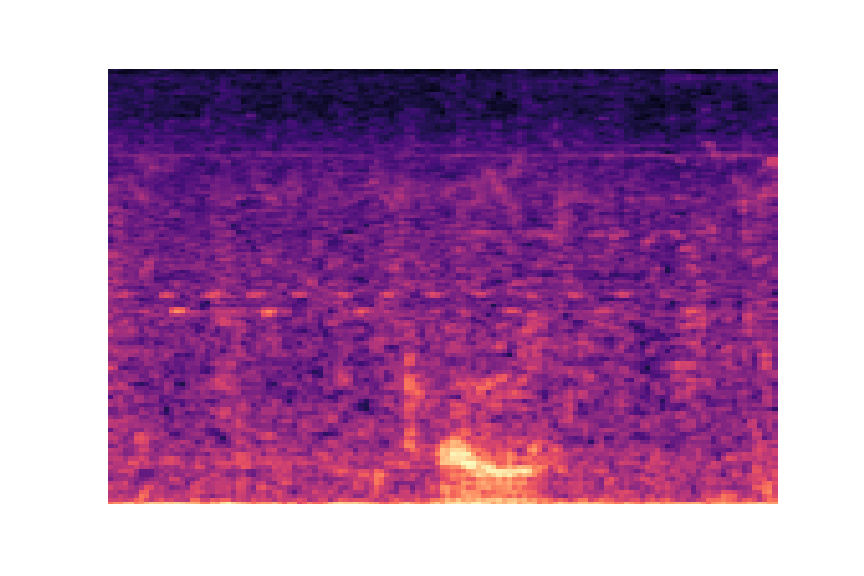

In [4]:
# Print a spectrogram
p = (path/PROCESSED_FOLDER).ls()[2]
img = PILImage.create(p); img

In [5]:
# Get an idea of the shape, 3 color channels, 576*864 pixels
tconv = ToTensor()
img = tconv(img)
img.shape,type(img)

(torch.Size([3, 576, 864]), fastai.torch_core.TensorImage)

In [6]:
df = pd.read_excel((path/f"{METADATA_FOLDER}/Age-sex calls- Dzanga Bai.xlsx"), sheet_name="context")
df.head()

,unique_ID,call_type,comb,in_analysis,final_cat,final_subcat,distress,age,sex,agsex
0,opp_330_ru,ru,n,y,nrs,nrs,na,juv,un,un
1,opp_332_ru,ru,n,y,logistics,leave,na,ad,f,adf
2,opp_333_ru,ru,n,y,unspecific,unspecific,na,ad,f,adf
3,opp_333_ru1,ru,n,y,unspecific,unspecific,na,ad,f,adf
4,opp_333_ru2,ru,n,y,unspecific,unspecific,na,ad,f,adf


In [7]:
#create spectrogram paths in dataframe
df["path"] = df['unique_ID'].apply(lambda x: f"{PROCESSED_FOLDER}/{x}.png")

In [8]:
#make sure paths exist
df["exists"] = df["path"].apply(lambda x: Path(x).is_file())

In [9]:
#Check all files in file exist as spectrograms
assert np.sum(df.exists) == len(df)

## Create Test set and cross-validation folds based on demographic characteristic

The rationale here is that we can have separate test sets that follow the distribution of the population depending on demographic characteristic of interest. 
This allows us to use more of the data. The balanced folds also allows cross-validation to be more representantive of the data distribution.


### Analysis for Age class prediction

We will follow a 80/20 Train/Test set. 
We also noticed missclasification between groups close in age so we will change this multiclass problem into a binary classification problem by grouping aduts/small adults and infants/juveniles

In [10]:
set(df.age.values)

{'ad', 'inf', 'juv', 'sa', 'un'}

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit


# keep only valid ages
dfx = df[df['age']!="un"]

# create age categorizations
dfx["agecat"] = df["age"].apply(lambda x: "ad/sa" if x in ("ad","sa") else "inf/juv")

# create stratified train/test splits
y = dfx.agecat.values
print(len(y),len(dfx), len(df))
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)

for train_idx, test_idx in sss.split(np.zeros(len(y)), y):
    print("TRAIN:", test_idx, "TEST:", test_idx)

# Bool to flag if image is part of the test set
dfx["is_test"] =  dfx.index.isin(test_idx)

# Save a copy of the train_test metadata
df.to_csv(f"{METADATA_FOLDER}/train_test_split.csv")

354 354 389
TRAIN: [ 93 312   9 185 206 294 305 248 172  17 104 341  23 304 340  99  90 267
 270  89   2 268  80 149 214  33 156 328 165 100  82  65 291 284 253 200
 345 242  27 180   0  86 323 220 135  78 353 169 283 339 233 134 281 118
 306  51  38  30 266 139 346 150 155 112  83 297 301 146 113 230 310] TEST: [ 93 312   9 185 206 294 305 248 172  17 104 341  23 304 340  99  90 267
 270  89   2 268  80 149 214  33 156 328 165 100  82  65 291 284 253 200
 345 242  27 180   0  86 323 220 135  78 353 169 283 339 233 134 281 118
 306  51  38  30 266 139 346 150 155 112  83 297 301 146 113 230 310]


/tmp/ipykernel_887494/1939441220.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx["agecat"] = df["age"].apply(lambda x: "ad/sa" if x in ("ad","sa") else "inf/juv")
/tmp/ipykernel_887494/1939441220.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx["is_test"] =  dfx.index.isin(test_idx)


In [12]:
# Keeping code in case needed
#from sklearn.model_selection import StratifiedShuffleSplit


#keep only valid ages
#dfx = df[df['age']!="un"]
#y = dfx.age.values
#print(len(y),len(dfx), len(df))
#sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)

#for train_idx, test_idx in sss.split(np.zeros(len(y)), y):
#    train_df=dfx[dfx.index.isin(train_idx)]
#    test_df=dfx[dfx.index.isin(test_idx)]

 
#print(f"Training set: {len(train_df)}, Hold out test set: {len(test_df)}")

In [13]:
df_temp = dfx[["path","agecat","age","is_test"]]
df_temp.head()

,path,agecat,age,is_test
0,../data/processed/opp_330_ru.png,inf/juv,juv,True
1,../data/processed/opp_332_ru.png,ad/sa,ad,False
2,../data/processed/opp_333_ru.png,ad/sa,ad,True
3,../data/processed/opp_333_ru1.png,ad/sa,ad,False
4,../data/processed/opp_333_ru2.png,ad/sa,ad,False


## Fitting the model

Model fitting was done externally, here we create the dataloader and view the images

In [14]:
from fastai.callback.fp16 import *

# Resizing by squishing to preserve image to 512, small batch size needed to fit into memory
dls = ImageDataLoaders.from_df(df_temp, path=".",  valid_col='is_test',bs=12,item_tfms=Resize(512, method="squish"))

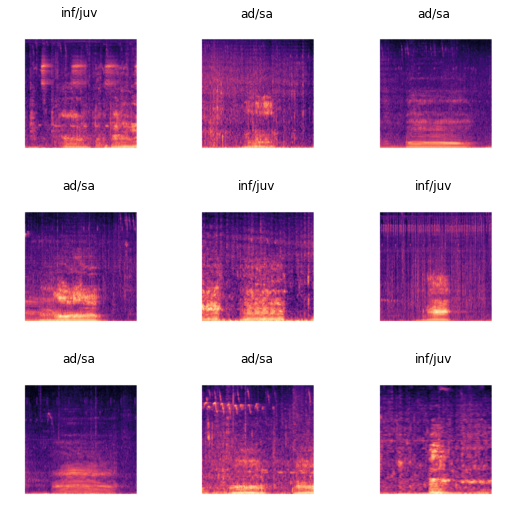

In [15]:
dls.show_batch()

In [26]:
# Specifying the model for diagnostic use
torch.cuda.empty_cache() 
learn = cnn_learner(dls, resnet152,                
                metrics=[accuracy, error_rate]).to_fp16()

In [27]:
# Early stopping, keep fitting till we have 5 consecutive episodes of validation error getting worse
 
#frozen training step
torch.cuda.empty_cache() 
learn.fit_one_cycle(20, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5),
                           SaveModelCallback(every_epoch=True, monitor='valid_loss')])

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.129838,8.674623,0.298507,0.701493,00:18
1,0.987133,0.598694,0.716418,0.283582,00:18
2,0.870261,0.697468,0.761194,0.238806,00:18
3,0.805938,1.141935,0.641791,0.358209,00:18
4,0.732678,0.800972,0.791045,0.208955,00:18
5,0.604717,0.839254,0.776119,0.223881,00:19
6,0.498691,0.844749,0.776119,0.223881,00:19


No improvement since epoch 1: early stopping


/home/karma/.local/share/virtualenvs/capstone_project-Bcy6YRu4/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=4.786300905834651e-06)

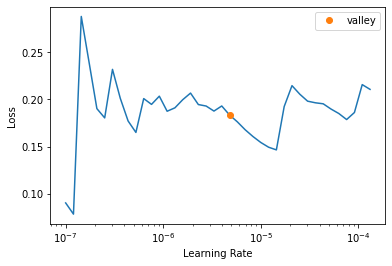

In [30]:
learn.unfreeze()
learn.lr_find()

In [32]:
learn.fit_one_cycle(20, lr_max=slice(1e-6,1e-5), cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5),
                           SaveModelCallback(every_epoch=True, monitor='valid_loss')])

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.144137,0.768269,0.835821,0.164179,00:22
1,0.148103,0.758816,0.761194,0.238806,00:22
2,0.134748,0.724673,0.746269,0.253731,00:22
3,0.147225,0.633631,0.776119,0.223881,00:22
4,0.147639,0.724089,0.805970,0.194030,00:23
5,0.136451,0.648817,0.805970,0.194030,00:23
6,0.117399,0.761609,0.761194,0.238806,00:23
7,0.108866,0.730006,0.761194,0.238806,00:23
8,0.090938,0.742807,0.776119,0.223881,00:23


No improvement since epoch 3: early stopping


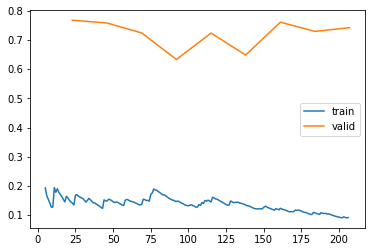

In [33]:
learn.recorder.plot_loss()

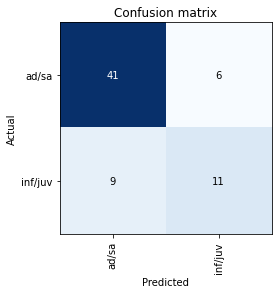

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [35]:
(11+41)/(35+14+18)

0.7761194029850746

In [36]:
learn.save('baseline_resnet152_2_age_class')

Path('models/baseline_resnet152_2_age_class.pth')

## Model performance and diagnostics

Loading the externally trained model

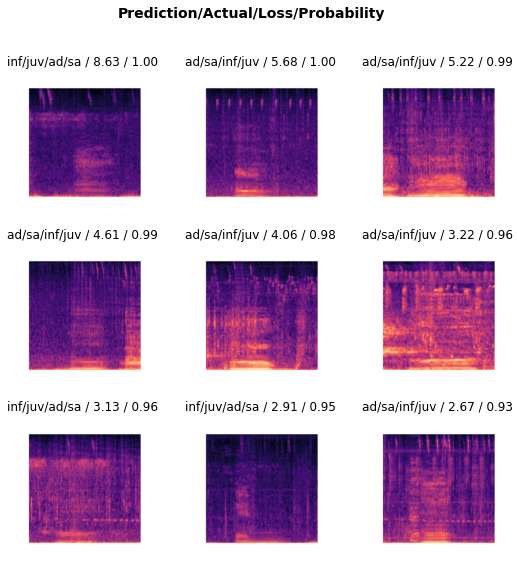

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)

### TODO: Next steps
- We have very few examples of infants, and most of the images we have are unlabelled, need to see if researchers can label more of the existing images. Only 354 out of 862 images are available for this analysis
- Mel spectrogram may need tweaking with different parameters SR, can check with Peter and go back to previous project15 values used
- Data augmentation has not been attempted, need to see how we can change the audio files to make sounds appear closer or further away, this will allow us to greatly scale up our training data
- Next model can be fitted using pytorch and making use of the audio layer to avoid creating mel spectrograms externally, this should prevent data loss
- Provide a CAM analysis so researchers can see why our models behave the way they do, eg: why does the model think this is a male etc..
- Share our initial finding and deployed model with the researchers in the form of a webapp that they can provide their initial feedback on.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7aa10abb-09ba-4e5c-b109-d1b9cd39afe4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>